In [31]:
#Built with inspiration from https://kidquant.com/project/pairs-trading-strategies-in-python/
import pandas as pd
import pandas_datareader as pdr
from datetime import datetime
import yfinance as yf

#dates picked from the outbreak of the Russian invasion of Ukraine to date
def get_historical_Data(tickers):
    """This function returns a pd dataframe with all of the adjusted closing information"""
    data = pd.DataFrame()
    names = list()
    for i in tickers:
        data = pd.concat([data, pd.DataFrame(yf.download(i, start=datetime(2022, 2, 24), end=datetime(2024, 6, 25)).iloc[:,4])], axis = 1)
        names.append(i)
    data.columns = names
    return data

ticks = ["NOC","LMT","BA","RTX","GD","HON","EADSF", "BAESY", "RKLB", "LHX"] #Tickers of defense sector stocks
d = get_historical_Data(ticks)
print(d.shape)
# Most Recent Data
d.tail()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

(585, 10)


,NOC,LMT,BA,RTX,GD,HON,EADSF,BAESY,RKLB,LHX
Date,,,,,,,,,,
2024-06-17,429.779999,459.010010,178.389999,104.470001,293.829987,211.949997,156.639999,68.570000,4.34,220.690002
2024-06-18,425.829987,460.000000,174.990005,104.769997,298.000000,212.869995,159.220001,68.690002,4.91,222.449997
2024-06-20,434.480011,466.339996,176.300003,105.070000,299.630005,214.139999,154.830002,68.410004,4.80,224.100006
2024-06-21,432.089996,467.600006,176.559998,105.610001,298.250000,215.089996,158.679993,67.139999,5.01,225.509995
2024-06-24,430.670013,471.510010,179.100006,101.959999,298.529999,215.889999,152.509995,68.410004,4.83,225.490005


In [32]:
#This mapping sees how well each stock correlates against each other, hence while the diagonal is all ones, each stock "correlates" with itself perfectly
corr_matrix = d.corr()
corr_matrix

,NOC,LMT,BA,RTX,GD,HON,EADSF,BAESY,RKLB,LHX
NOC,1.000000,0.345831,-0.213907,0.067596,0.249707,0.274249,-0.156106,-0.105410,-0.388581,0.218518
LMT,0.345831,1.000000,0.483468,0.547160,0.432860,0.708184,0.526232,0.457019,-0.200605,-0.173702
BA,-0.213907,0.483468,1.000000,-0.022638,0.095235,0.481218,0.559286,0.416176,0.131337,-0.558301
RTX,0.067596,0.547160,-0.022638,1.000000,0.396832,0.470771,0.286617,0.237356,0.001880,0.399260
GD,0.249707,0.432860,0.095235,0.396832,1.000000,0.529276,0.709369,0.779010,-0.246118,0.207902
HON,0.274249,0.708184,0.481218,0.470771,0.529276,1.000000,0.575729,0.460875,-0.095063,-0.064923
EADSF,-0.156106,0.526232,0.559286,0.286617,0.709369,0.575729,1.000000,0.947454,-0.196909,-0.333438
BAESY,-0.105410,0.457019,0.416176,0.237356,0.779010,0.460875,0.947454,1.000000,-0.338749,-0.301483
RKLB,-0.388581,-0.200605,0.131337,0.001880,-0.246118,-0.095063,-0.196909,-0.338749,1.000000,0.323742
LHX,0.218518,-0.173702,-0.558301,0.399260,0.207902,-0.064923,-0.333438,-0.301483,0.323742,1.000000


<Axes: >

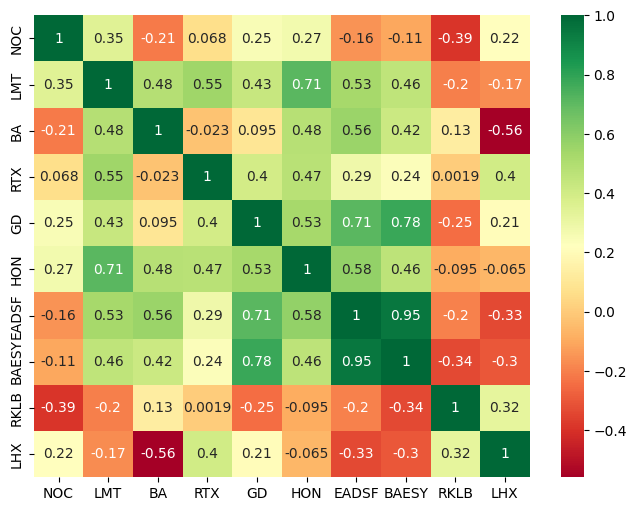

In [33]:
#To visualize the above table consider the below heatmap
import seaborn as sn
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=100)
sn.heatmap(corr_matrix, annot = True, cmap="RdYlGn")

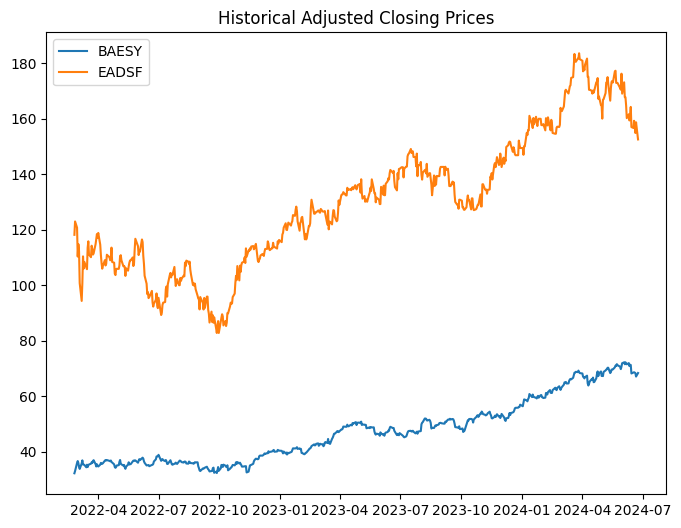

In [34]:
#Let's see how two individual stocks compare to each other, specifically two with a high(.95) correlation from the above heatmap
import matplotlib.pyplot as plt
figure(figsize=(8, 6), dpi=100)
BAESY = d['BAESY']
EADSF = d['EADSF']
plt.plot(BAESY, label = "BAESY")
plt.plot(EADSF, label = "EADSF")
plt.title('Historical Adjusted Closing Prices')
plt.legend()

Text(0.5, 1.0, 'Spread between BAESY and EADSF')

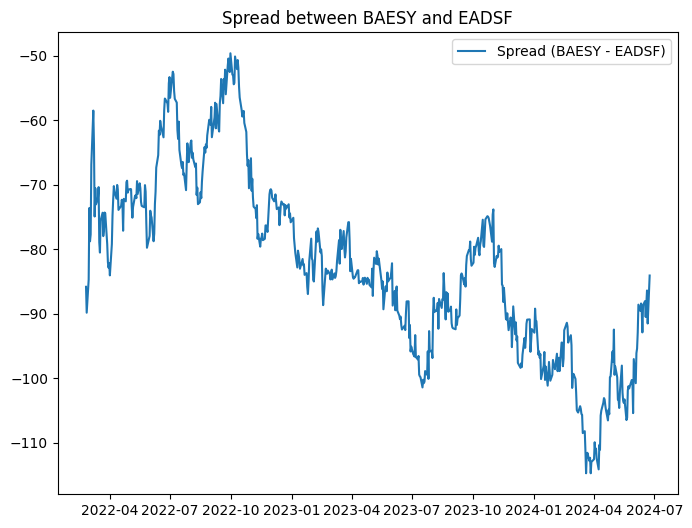

In [35]:
#Utilizing this trading strategy generally means profiting off the spread, so let's examine that
figure(figsize=(8, 6), dpi=100)
plt.plot(BAESY - EADSF, label = 'Spread (BAESY - EADSF)')
plt.legend()
plt.title("Spread between BAESY and EADSF")

In [36]:
#The above graph is only marginally clearer, let's dive into some of the math 
import statsmodels.tsa.stattools as ts 
result = ts.coint(BAESY, EADSF)
#From this cointegration test, we'll see any potential correlation between the two time series
cointegration_t_statistic = result[0]
p_val = result[1]
critical_values_test_statistic_at_1_5_10 = result[2]
#Note that we're interested in a p value<.05
print('P value for the Augmented Engle-Granger two-step cointegration test is', p_val)

P value for the Engle-Granger two-step cointegration test is 0.025776044735348905


In [37]:
from statsmodels.tsa.stattools import adfuller
# In order properly analyze our data, it is important that we have stationary data, or it will be very challenging to make predictions
BAESY_ADF = adfuller(BAESY)
print('P value for the Augmented Dickey-Fuller Test is', BAESY_ADF[1])
EADSF_ADF = adfuller(EADSF)
print('P value for the Augmented Dickey-Fuller Test is', EADSF_ADF[1])
Spread_ADF = adfuller(BAESY - EADSF)
print('P value for the Augmented Dickey-Fuller Test is', Spread_ADF[1])
Ratio_ADF = adfuller(BAESY / EADSF)
print('P value for the Augmented Dickey-Fuller Test is', Ratio_ADF[1])

#We can see that the ADF tests for BAESY and EADSF suggest that the ratio between them is stationary


P value for the Augmented Dickey-Fuller Test is 0.9470953853899244
P value for the Augmented Dickey-Fuller Test is 0.7948244722313976
P value for the Augmented Dickey-Fuller Test is 0.36409376163746543
P value for the Augmented Dickey-Fuller Test is 0.019817311158974567


Text(0.5, 1.0, 'Price Ratio between BAESY and EADSF')

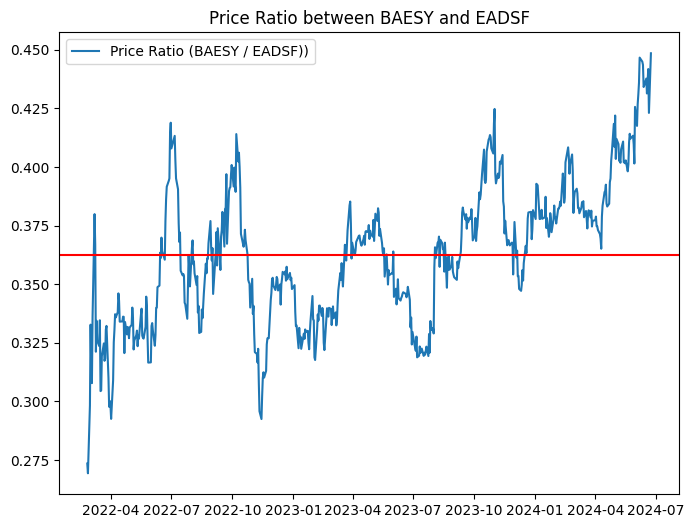

In [38]:
# Also, we can take a look at the price ratios between the two time series.
figure(figsize=(8, 6), dpi=100)
ratio = BAESY / EADSF
plt.plot(ratio, label = 'Price Ratio (BAESY / EADSF))')
plt.axhline(ratio.mean(), color='red')
plt.legend()
plt.title("Price Ratio between BAESY and EADSF")

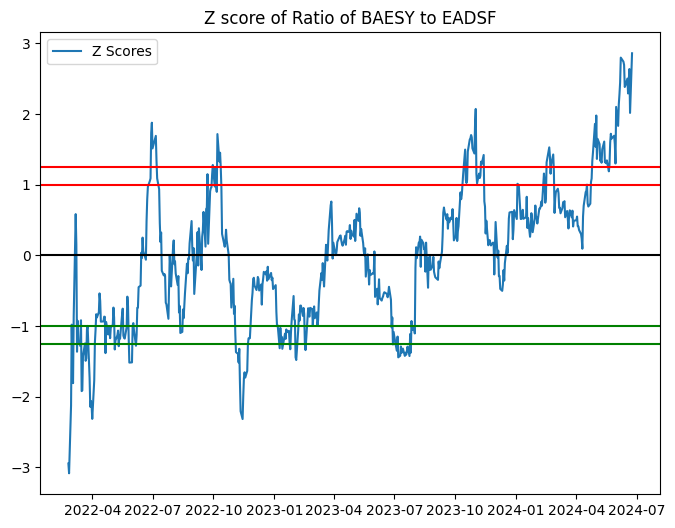

In [40]:
figure(figsize=(8, 6), dpi=100)
# Calculate the Zscores of each row.
df_zscore = (ratio - ratio.mean())/ratio.std()
plt.plot(df_zscore, label = "Z Scores")
plt.axhline(df_zscore.mean(), color = 'black')
plt.axhline(1.0, color='red') # Setting the upper and lower bounds to be the z score of 1 and -1 (1/-1 standard deviation)
plt.axhline(1.25, color='red') # 95% of our data will lie between these bounds.
plt.axhline(-1.0, color='green') # 68% of our data will lie between these bounds.
plt.axhline(-1.25, color='green') # 95% of our data will lie between these bounds.
plt.legend(loc = 'best')
plt.title('Z score of Ratio of BAESY to EADSF')
plt.show()
# For the most part, the range that exists outside of these 'bands' must come converge back to the mean. Thus, you can 
# determine when you can go long or short the pair (BAESY to EADSF).

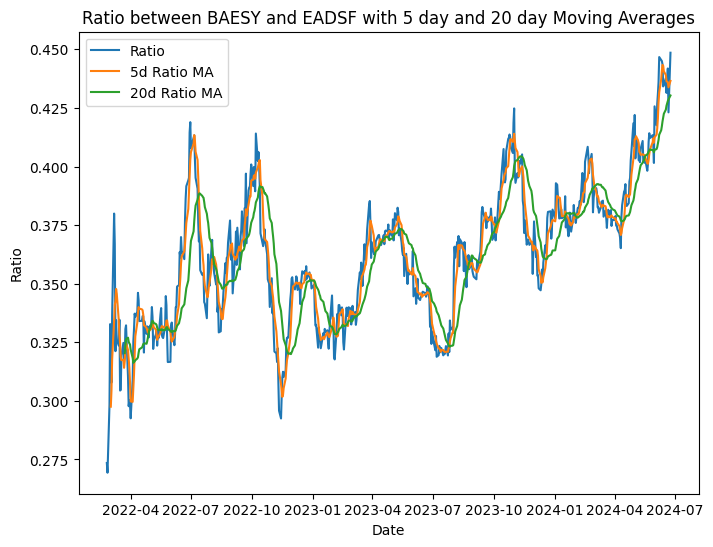

In [42]:
figure(figsize=(8, 6), dpi=100)
ratios_mavg5 = ratio.rolling(window=5, center=False).mean()
ratios_mavg20 = ratio.rolling(window=20, center=False).mean()
std_20 = ratio.rolling(window=20, center=False).std()
zscore_20_5 = (ratios_mavg5 - ratios_mavg20)/std_20
plt.plot(ratio.index, ratio.values)
plt.plot(ratios_mavg5.index, ratios_mavg5.values)
plt.plot(ratios_mavg20.index, ratios_mavg20.values)
plt.legend(['Ratio', '5d Ratio MA', '20d Ratio MA'])
plt.xlabel('Date')
plt.ylabel('Ratio')
plt.title('Ratio between BAESY and EADSF with 5 day and 20 day Moving Averages')
plt.show()

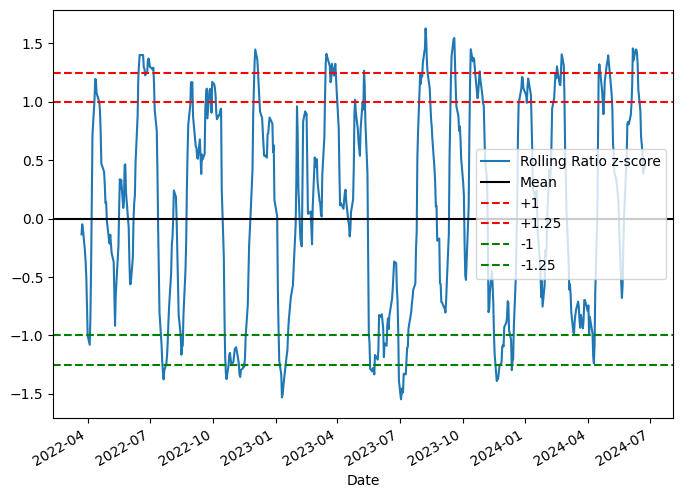

In [44]:
figure(figsize=(8, 6), dpi=100)
zscore_20_5.plot()
plt.axhline(0, color='black')
plt.axhline(1, color='red', linestyle='--')
plt.axhline(1.25, color='red', linestyle='--')
plt.axhline(-1, color='green', linestyle='--')
plt.axhline(-1.25, color='green', linestyle='--')
plt.legend(['Rolling Ratio z-score', 'Mean', '+1','+1.25','-1','-1.25'])
plt.show()

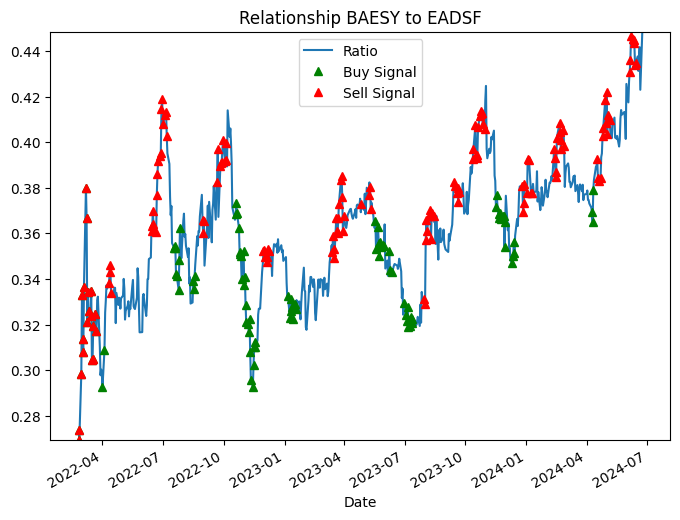

In [46]:
figure(figsize=(8, 6), dpi=100)
ratio.plot()
buy = ratio.copy()
sell = ratio.copy()
buy[zscore_20_5>-1] = 0
sell[zscore_20_5<1] = 0
buy.plot(color='g', linestyle='None', marker='^')
sell.plot(color='r', linestyle='None', marker='^')
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, ratio.min(), ratio.max()))
plt.legend(['Ratio', 'Buy Signal', 'Sell Signal'])
plt.title('Relationship BAESY to EADSF')
plt.show()